## Load Packages

In [2]:
import numpy
import matplotlib.pyplot as plt
import math
import torch

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

## Load and Split Dataset

In [26]:
transform = ToTensor()

train_set = MNIST(
    root='~/datasets', train=True, download=True, transform=transform
)

test_set = MNIST(
    root='~/datasets', train=False, download=True, transform=transform
)

In [5]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_set, shuffle=False, batch_size=BATCH_SIZE)

In [6]:
for X, y in train_dataloader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f' Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
 Shape of y: torch.Size([64]) torch.int64


## Visualize MNIST Data

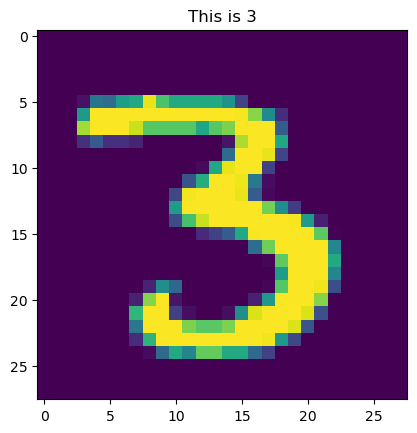

In [28]:
f=12
plt.imshow(train_set.data[f])
plt.title('This is %i' % train_set.targets[f])
plt.show()

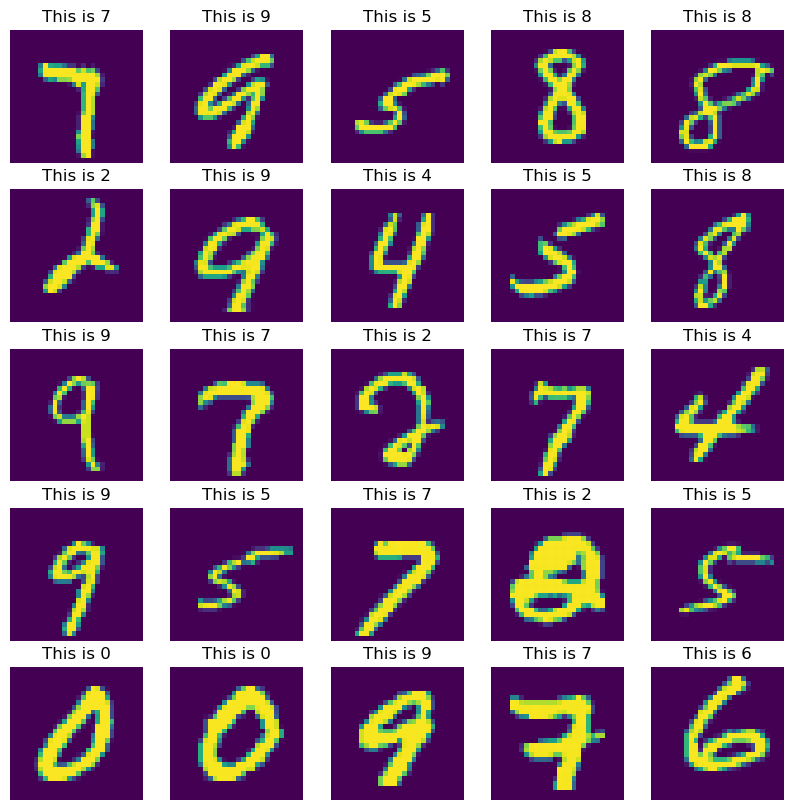

In [8]:
figure = plt.figure(figsize=(10,10))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_set.data), size=(1,)).item()
    img, label = train_set.data[sample_idx], train_set.targets[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title('This is '+str(label))
    plt.axis('off')
    plt.imshow(img.squeeze())
plt.show()

## Neural Network Class

In [9]:
from torch import nn
from torch import optim

In [10]:
device = ('Cuda' if torch.cuda.is_available() else 'cpu')
print(f'Network using {device} device')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_ReLU_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        result = self.linear_ReLU_stack(x)
        return result

model = NeuralNetwork()
print(model)

Network using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_ReLU_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

## Training Cycle

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute the prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

# check the model's performance against the test dataset 
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Average loss: {test_loss:>8f} \n")

In [15]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done")

Epoch 1
-------------------------------
loss: 2.302894 [   64/60000]
loss: 2.291454 [ 6464/60000]
loss: 2.308935 [12864/60000]
loss: 2.283702 [19264/60000]
loss: 2.298940 [25664/60000]
loss: 2.289235 [32064/60000]
loss: 2.300156 [38464/60000]
loss: 2.294311 [44864/60000]
loss: 2.273947 [51264/60000]
loss: 2.282330 [57664/60000]
Test Error: 
 Accuracy: 32.0%, Average loss: 2.273183 

Epoch 2
-------------------------------
loss: 2.273865 [   64/60000]
loss: 2.293952 [ 6464/60000]
loss: 2.252903 [12864/60000]
loss: 2.271170 [19264/60000]
loss: 2.265964 [25664/60000]
loss: 2.241022 [32064/60000]
loss: 2.234448 [38464/60000]
loss: 2.244060 [44864/60000]
loss: 2.235394 [51264/60000]
loss: 2.217184 [57664/60000]
Test Error: 
 Accuracy: 42.8%, Average loss: 2.227340 

Epoch 3
-------------------------------
loss: 2.230899 [   64/60000]
loss: 2.222891 [ 6464/60000]
loss: 2.203959 [12864/60000]
loss: 2.208094 [19264/60000]
loss: 2.202338 [25664/60000]
loss: 2.181997 [32064/60000]
loss: 2.179859

### Save Model Parameters

In [18]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Loading and Testing Model

In [20]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [24]:
classes = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine"
]

model.eval()
x, y = test_set[0][0], test_set[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "seven", Actual: "seven"
